In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import time
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

if os.path.exists('/media/ssd_2tb_evo/DL_based_wind_profile_estimation'):
    root_dir = '/media/ssd_2tb_evo/DL_based_wind_profile_estimation'
elif os.path.exists('/home/harish/Ongoing_Research/DL_based_wind_profile_estimation'):
    root_dir = '/home/harish/Ongoing_Research/DL_based_wind_profile_estimation'
else:
    root_dir = '/Users/harishbaki/Ongoing_Research/DL_based_wind_profile_estimation'
sys.path.append(root_dir)
from libraries import *
from plotters import *

print('Last updated: ', datetime.now())

Last updated:  2025-04-18 18:47:41.746696


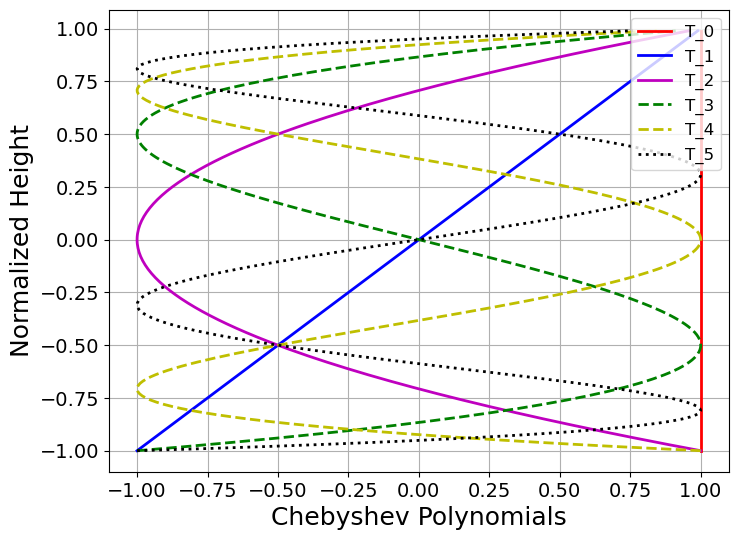

In [13]:
x = np.arange(-1, 1, 0.01)
CP = Chebyshev_Basu(x, 6, CPtype)

plt.figure(figsize=(8, 6))

plt.plot(CP[:, 0], x, '-r', linewidth=2)
plt.plot(CP[:, 1], x, '-b', linewidth=2)
plt.plot(CP[:, 2], x, '-m', linewidth=2)
plt.plot(CP[:, 3], x, '--g', linewidth=2)
plt.plot(CP[:, 4], x, '--y', linewidth=2)
plt.plot(CP[:, 5], x, ':k', linewidth=2)

plt.legend(['T_0', 'T_1', 'T_2', 'T_3', 'T_4', 'T_5'], loc='upper right', fontsize=12)
plt.xlabel('Chebyshev Polynomials', fontsize=18)
plt.ylabel('Normalized Height', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

plt.savefig('chebyshev_polynomials.png')

In [2]:
ds = xr.open_dataset('../data/CERRA_height_level/2000.nc')
ds.lat[0].values,ds.lon[0].values
M = ds.data.isel(time=0,obs=0).data
Z = ds.heightAboveGround.data
CPtype = 1
p = 4
print('sample wind:',M,' and sample height: ',Z)

sample wind: [ 8.63973579  8.77258289  9.15604775  9.44329194  9.68862232  9.8606943
 10.11217974 10.33011622 10.72232818 11.30109832 11.86516703 11.48229358]  and sample height:  [ 10.  15.  30.  50.  75. 100. 150. 200. 250. 300. 400. 500.]


Bias: 0.0026
MAE: 0.0512
RMSE: 0.0658
Rmax: 0.1541


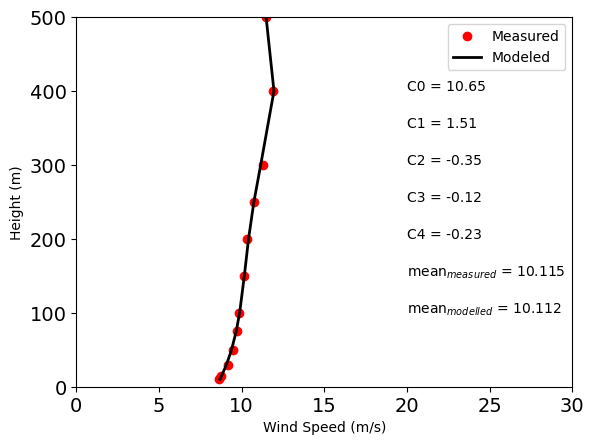

In [15]:
p = 4
Coeff = Chebyshev_Coeff(Z, M,p, CPtype)
Mp = WindProfile(Z,Coeff)
# Calculate statistics
Bias = np.mean(M - Mp)
MAE = np.mean(np.abs(M - Mp))
RMSE = np.sqrt(np.mean((M - Mp)**2))
Rmax = np.max(np.abs(M - Mp))

# Print the statistics
print(f'Bias: {Bias:.4f}')
print(f'MAE: {MAE:.4f}')
print(f'RMSE: {RMSE:.4f}')
print(f'Rmax: {Rmax:.4f}')

# Create Coeff_tot array
Coeff_tot = np.zeros(10)
Coeff_tot[:len(Coeff)] = Coeff

# Plot and save the figure
fig, ax = plt.subplots()
ax.plot(M, Z, 'or', markerfacecolor='r')
ax.plot(Mp, Z, '-k', linewidth=2)
ax.set(xlabel='Wind Speed (m/s)', ylabel='Height (m)')
ax.set_xlim([0, 30])
ax.set_ylim([0, 500])
ax.tick_params(labelsize=14)
ax.legend(['Measured', 'Modeled'])
plt.text(20, 400, f'C0 = {Coeff_tot[0]:.2f}')
plt.text(20, 350, f'C1 = {Coeff_tot[1]:.2f}')
plt.text(20, 300, f'C2 = {Coeff_tot[2]:.2f}')
plt.text(20, 250, f'C3 = {Coeff_tot[3]:.2f}')
plt.text(20, 200, f'C4 = {Coeff_tot[4]:.2f}')
plt.text(20, 150, fr'mean$_{{measured}}$ = {M.mean():.3f}')
plt.text(20, 100, fr'mean$_{{modelled}}$ = {Mp.mean():.3f}')
plt.savefig('chebyshev_fit_with_p4_CERRA_data.png')

# Estimating Chebyshev coefficients for CERRA

In [ ]:
ds = xr.open_mfdataset('/Users/hbaki/surfdrive/Ongoing_research/CERRA_height_level/*.nc',
                       combine='nested',
                       concat_dim='time')
Z = ds.heightAboveGround.data
# Number of observations, time steps, and height levels
n_obs, n_time, n_height = ds.data.shape
# Set p value
p = 4
# Initialize Coeff array
Coeff = np.zeros((n_obs, n_time, p+1))
# Iterate over observations and time steps
for i in range(n_obs):
    U = ds.data.isel(obs=i).data.compute()
    stime = time.time()
    for t in range(n_time):
        Coeff[i, t, :] = Chebyshev_Coeff(Z,U[t, :], p, CPtype)
    etime = time.time()
    print(f'Time elapsed for obs: {i}: {etime-stime}s')
coeff_da = xr.DataArray(Coeff, dims=['obs','time', 'coeff'], coords={'obs':ds.obs,'time': ds.time, 'coeff': np.arange(p+1)},name='data')
coeff_da.to_netcdf('Data/Chebyshev_Coefficnents.nc')

# Estimating Chebyshev coefficients for CERRA, only upto 300 m

In [21]:
ds = xr.open_mfdataset('../data/CERRA_height_level/*.nc',
                       combine='nested',
                       concat_dim='time')
Z = ds.heightAboveGround.data[:-2] # Considering height only up to 300m
ref_H = np.unique(np.concatenate((np.array([0]),Z))) # Adding 0 to the height levels
print('Z:',Z, ' and ref_H:',ref_H)
# Number of observations, time steps, and height levels
n_obs, n_time, n_height = ds.sel(heightAboveGround=Z).data.shape
# Set p value
p = 4
# Initialize Coeff array
Coeff = np.zeros((n_obs, n_time, p+1))
# Iterate over observations and time steps
for i in range(n_obs):
    U = ds.sel(heightAboveGround=Z).data.isel(obs=i).data.compute()
    stime = time.time()
    for t in range(n_time):
        Coeff[i, t, :] = Chebyshev_Coeff(Z,U[t, :], p, CPtype,ref_H = ref_H)
    etime = time.time()
    print(f'Time elapsed for obs: {i}: {etime-stime}s')
coeff_da = xr.DataArray(Coeff, dims=['obs','time', 'coeff'], coords={'obs':ds.obs,'time': ds.time, 'coeff': np.arange(p+1)},name='data')
coeff_da.to_netcdf('../data/CERRA_Chebyshev_Coefficnents_300m.nc')

Z: [ 10.  15.  30.  50.  75. 100. 150. 200. 250. 300.]  and ref_H: [  0.  10.  15.  30.  50.  75. 100. 150. 200. 250. 300.]
Time elapsed for obs: 0: 26.460749864578247s
Time elapsed for obs: 1: 26.426823139190674s
Time elapsed for obs: 2: 26.36771845817566s
Time elapsed for obs: 3: 26.681512355804443s
Time elapsed for obs: 4: 26.72729802131653s
Time elapsed for obs: 5: 26.9194176197052s
Time elapsed for obs: 6: 26.577175617218018s
Time elapsed for obs: 7: 26.51600480079651s
Time elapsed for obs: 8: 26.572661638259888s
Time elapsed for obs: 9: 26.856934785842896s
Time elapsed for obs: 10: 26.105761528015137s


## Plotting sample wind profiles from CERRA and Chebyshev modelled

In [23]:
CERRA_ds = xr.open_mfdataset('../data/CERRA_height_level/*.nc',
                       combine='nested',
                       concat_dim='time')
Z_CERRA = CERRA_ds.heightAboveGround.data[:-2]
ChSh_Coeff = xr.open_dataset('../data/CERRA_Chebyshev_Coefficnents_300m.nc')
normalize(Z_CERRA)

array([-1.        , -0.97959184, -0.91836735, -0.83673469, -0.73469388,
       -0.63265306, -0.42857143, -0.2244898 , -0.02040816,  0.18367347])

In [24]:
dates_range =  ('2001-01-01T00:00:00','2001-12-31T23:00:00')
obs = 0
CERRA_ds_subset = CERRA_ds.sel(time=slice(*dates_range),obs = obs,heightAboveGround=Z_CERRA).to_array().values
CERRA_ds_subset = CERRA_ds_subset[0,...]
ChSh_Coeff_subset = ChSh_Coeff.sel(time=slice(*dates_range),obs = obs).to_array().values
ChSh_Coeff_subset = ChSh_Coeff_subset[0,...]

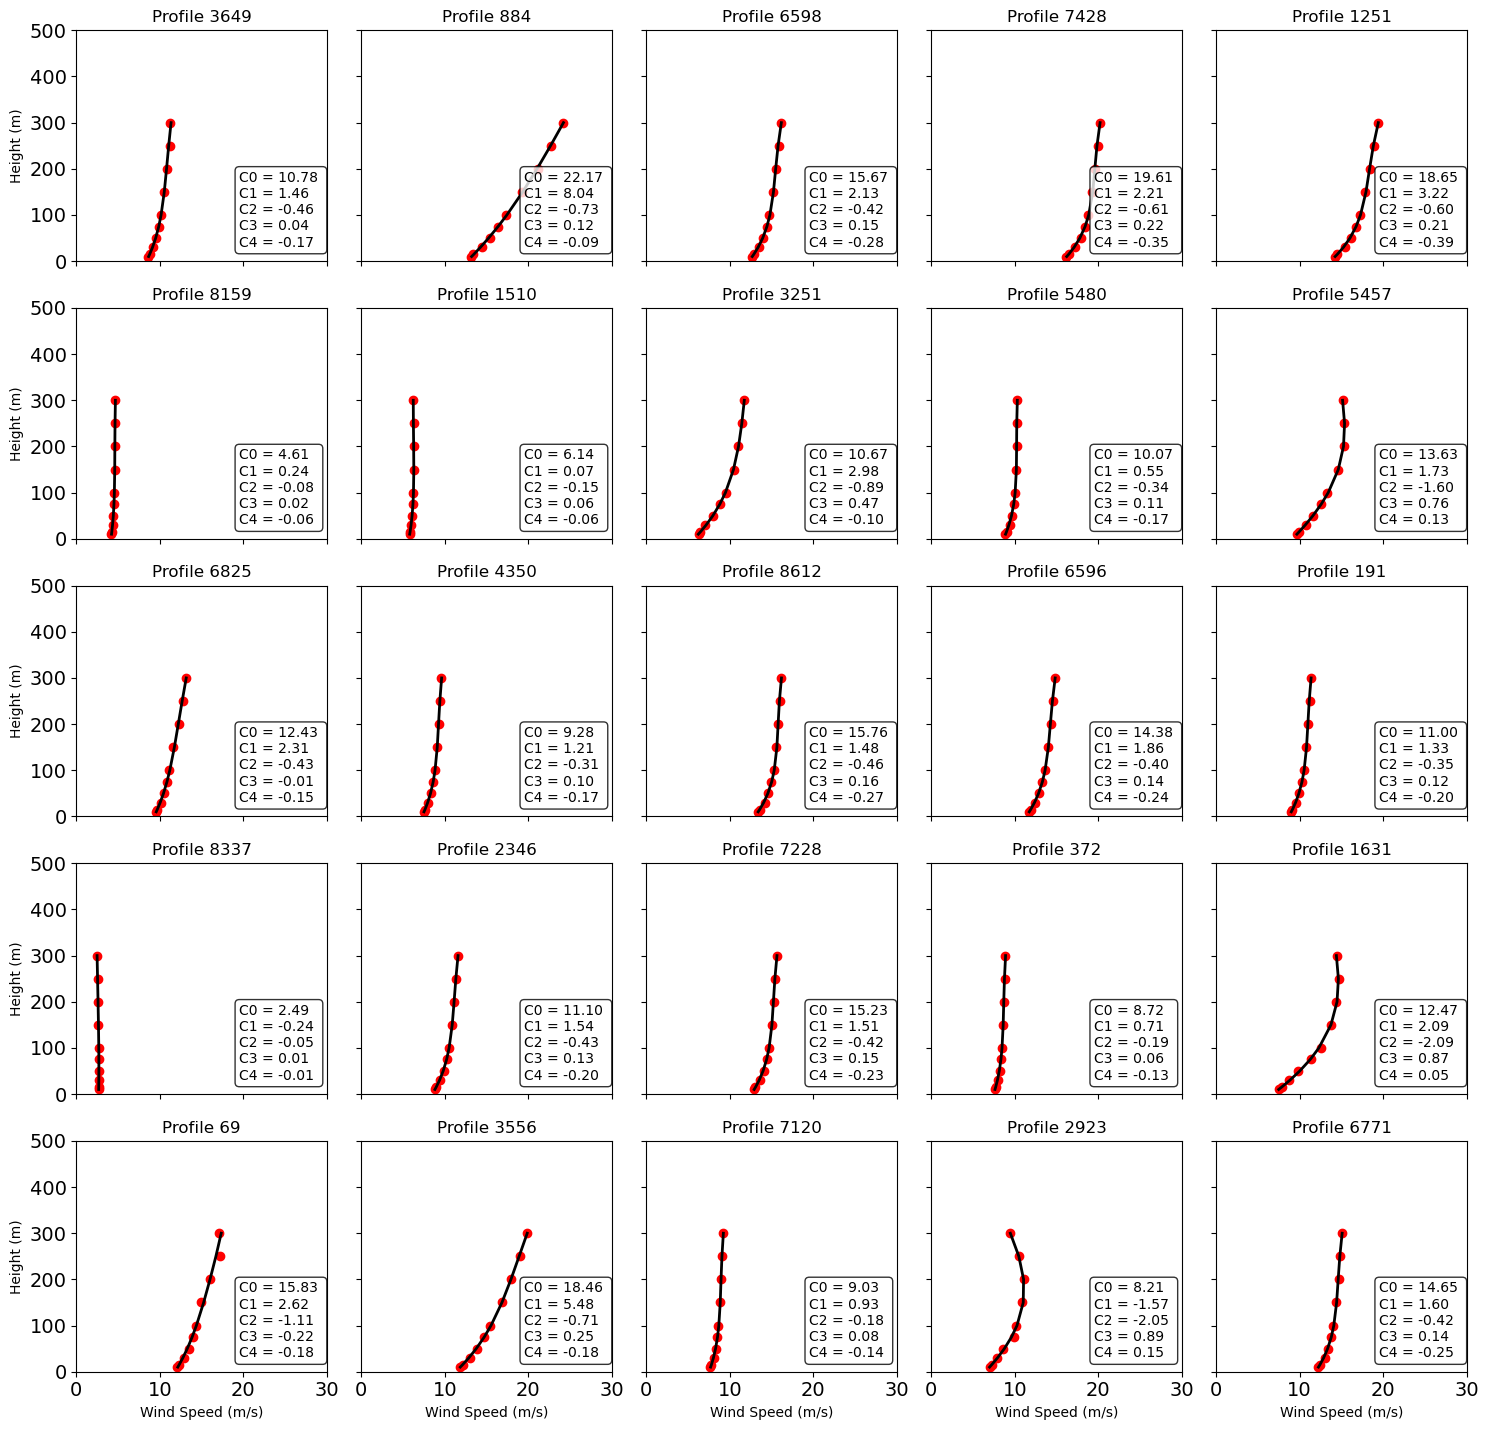

In [25]:
# Set a seed for reproducibility
np.random.seed(9)

# Select 25 random samples
random_indices = np.random.choice(len(CERRA_ds_subset), size=25, replace=False)

# Create a 5x5 grid of subplots
fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)

# Plot the selected samples
for i, ax in zip(random_indices, axs.flatten()):
    M = CERRA_ds_subset[i, :]
    Mp = WindProfile(Z_CERRA, ChSh_Coeff_subset[i,:])
    ax.plot(M, Z_CERRA, 'or', markerfacecolor='r',label='CERRA')
    ax.plot(Mp, Z_CERRA, '-k', linewidth=2,label='Chebyshev modelled')

    ax.text(0.65, 0.05, f'C0 = {ChSh_Coeff_subset[i,0]:.2f} \nC1 = {ChSh_Coeff_subset[i,1]:.2f}'
            f'\nC2 = {ChSh_Coeff_subset[i,2]:.2f} \nC3 = {ChSh_Coeff_subset[i,3]:.2f} \nC4 = {ChSh_Coeff_subset[i,4]:.2f}',
                      transform=ax.transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    ax.set_xlim([0, 30])
    ax.set_ylim([0, 500])
    ax.tick_params(labelsize=14)
    ax.set_title(f'Profile {i}')

# Set common labels
for ax in axs.flat:
    ax.set(xlabel='Wind Speed (m/s)', ylabel='Height (m)')
    ax.label_outer()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
#plt.savefig('Figures/chebyshev_fit_with_p4_real_data.pdf',dpi=300,bbox_inches='tight',pad_inches=0)

# Chebyshev coefficients estimation for Heligoland observations

In [3]:
obs_levels = np.array([40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 450, 500])
df_Obs = pd.read_csv('Heligoland_wind.csv',index_col=0,parse_dates=True)
print(df_Obs.head())
# Resampling the data to hourly frequency, by averaging the values
df_Obs = df_Obs.resample('H').mean() #['Obs_wind_speed']['ws_50_m']
print(df_Obs.head())    

                     ws_40_m  ws_50_m  ws_60_m  ws_70_m  ws_80_m  ws_90_m  \
2017-03-23 12:10:00     8.67     9.19     9.68    10.19    10.63    10.93   
2017-03-23 12:20:00     8.21     8.77     9.24     9.67    10.13    10.45   
2017-03-23 12:30:00     7.59     8.05     8.63     9.11     9.58    10.03   
2017-03-23 12:40:00     7.71     7.96     8.34     8.83     9.43    10.01   
2017-03-23 12:50:00     7.94     8.55     9.22     9.82    10.35    10.78   

                     ws_100_m  ws_120_m  ws_140_m  ws_160_m  ...  ws_260_m  \
2017-03-23 12:10:00     11.11     10.99     10.60     10.22  ...     10.26   
2017-03-23 12:20:00     10.69     10.92     10.91     10.72  ...     10.76   
2017-03-23 12:30:00     10.41     10.73     10.69     10.64  ...     11.28   
2017-03-23 12:40:00     10.53     11.06     11.10     11.06  ...     11.36   
2017-03-23 12:50:00     11.15     11.64     11.67     11.66  ...     11.45   

                     ws_280_m  ws_300_m  ws_320_m  ws_340_m  ws_360_

In [3]:
# find the index of completely empty rows
empty_rows = df_Obs.index[df_Obs.isnull().all(axis=1)]
# find the index of rows with at least one missing value
missing_rows = df_Obs.index[df_Obs.isnull().any(axis=1)]
# find the index of rows with no missing values
non_missing_rows = df_Obs.index[~df_Obs.isnull().any(axis=1)]
print('Number of empty rows: ', len(empty_rows),'\n', 
      'Number of rows with missing values: ', len(missing_rows), '\n',
      'Number of rows with no missing values: ', len(non_missing_rows))

print(f'Now, the Idea is to use the {len(non_missing_rows)} values in Tabnet training, validation and testing.')
n_train = round(0.7*len(non_missing_rows))
n_val = round(0.2*len(non_missing_rows))
n_test = len(non_missing_rows) - n_train - n_val
print(f'In which, {n_train} for training, {n_val} for validation and {n_test} for testing.')
print(f'Post training, the missing data of {len(missing_rows)} rows will be predicted using the trained model.\n' 
      'This step is synonymous to the TabNet testing, since some partial observations does exist for these rows.')
print(f'And the empty rows {len(empty_rows)} will be filled using the trained TabNet predictions.')


Number of empty rows:  475 
 Number of rows with missing values:  2202 
 Number of rows with no missing values:  7026
Now, the Idea is to use the 7026 values in Tabnet training, validation and testing.
In which, 4918 for training, 1405 for validation and 703 for testing.
Post training, the missing data of 2202 rows will be predicted using the trained model.
This step is synonymous to the TabNet testing, since some partial observations does exist for these rows.
And the empty rows 475 will be filled using the trained TabNet predictions.


In [4]:
M = df_Obs.loc['2017-03-23T12:00:00':'2017-03-23T12:00:00'].values[0]
Z = obs_levels
CPtype = 1
p = 4
print('sample wind:',M,' and sample height: ',Z, normalize(Z))

sample wind: [ 8.024  8.504  9.022  9.524 10.024 10.44  10.778 11.068 10.994 10.86
 10.772 10.734 10.778 10.894 11.022 11.132 11.216 11.254 11.274 11.226
 11.19  11.164 11.106 11.074]  and sample height:  [ 40  50  60  70  80  90 100 120 140 160 180 200 220 240 260 280 300 320
 340 360 380 400 450 500] [-0.87755102 -0.83673469 -0.79591837 -0.75510204 -0.71428571 -0.67346939
 -0.63265306 -0.55102041 -0.46938776 -0.3877551  -0.30612245 -0.2244898
 -0.14285714 -0.06122449  0.02040816  0.10204082  0.18367347  0.26530612
  0.34693878  0.42857143  0.51020408  0.59183673  0.79591837  1.        ]


Bias: -0.0110
MAE: 0.1953
RMSE: 0.2215
Rmax: 0.4030


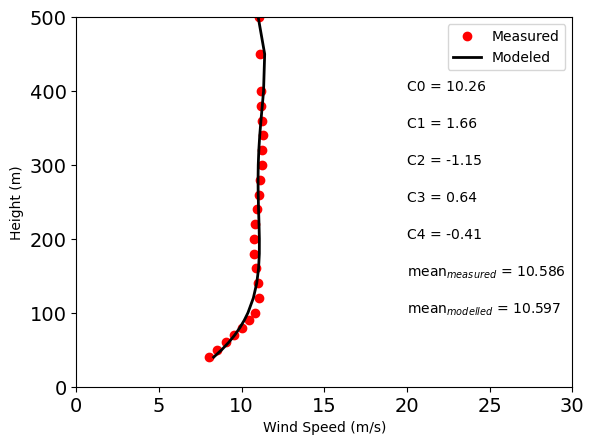

In [5]:
p = 4
Coeff = Chebyshev_Coeff(Z, M,p, CPtype)
Mp = WindProfile(Z,Coeff)
# Calculate statistics
Bias = np.mean(M - Mp)
MAE = np.mean(np.abs(M - Mp))
RMSE = np.sqrt(np.mean((M - Mp)**2))
Rmax = np.max(np.abs(M - Mp))

# Print the statistics
print(f'Bias: {Bias:.4f}')
print(f'MAE: {MAE:.4f}')
print(f'RMSE: {RMSE:.4f}')
print(f'Rmax: {Rmax:.4f}')

# Create Coeff_tot array
Coeff_tot = np.zeros(10)
Coeff_tot[:len(Coeff)] = Coeff

# Plot and save the figure
fig, ax = plt.subplots()
ax.plot(M, Z, 'or', markerfacecolor='r')
ax.plot(Mp, Z, '-k', linewidth=2)
ax.set(xlabel='Wind Speed (m/s)', ylabel='Height (m)')
ax.set_xlim([0, 30])
ax.set_ylim([0, 500])
ax.tick_params(labelsize=14)
ax.legend(['Measured', 'Modeled'])
plt.text(20, 400, f'C0 = {Coeff_tot[0]:.2f}')
plt.text(20, 350, f'C1 = {Coeff_tot[1]:.2f}')
plt.text(20, 300, f'C2 = {Coeff_tot[2]:.2f}')
plt.text(20, 250, f'C3 = {Coeff_tot[3]:.2f}')
plt.text(20, 200, f'C4 = {Coeff_tot[4]:.2f}')
plt.text(20, 150, fr'mean$_{{measured}}$ = {M.mean():.3f}')
plt.text(20, 100, fr'mean$_{{modelled}}$ = {Mp.mean():.3f}')
plt.savefig('chebyshev_fit_with_p4_Heligoland_data.png')

In [6]:
# Number of observations, time steps, and height levels
n_time, n_height = df_Obs.loc[non_missing_rows].shape
# Set p value
p = 4
# Initialize Coeff array
Coeff = np.zeros(( n_time, p+1))
U = df_Obs.loc[non_missing_rows].values

stime = time.time()
for t in range(n_time):
    Coeff[t, :] = Chebyshev_Coeff(Z,U[t, :], p, CPtype)
etime = time.time()

print(f'Time elapsed: {etime-stime}s')
coeff_da = xr.DataArray(Coeff, dims=['time', 'coeff'], coords={'time': non_missing_rows, 'coeff': np.arange(p+1)},name='data')
coeff_da.to_netcdf('Heligoland_Chebyshev_Coefficnents.nc')


Time elapsed: 2.0082876682281494s


In [2]:
xr.open_dataset('Heligoland_Chebyshev_Coefficnents.nc')

<xarray.Dataset>
Dimensions:  (time: 7026, coeff: 5)
Coordinates:
  * time     (time) datetime64[ns] 2017-03-23T12:00:00 ... 2018-04-11T23:00:00
  * coeff    (coeff) int64 0 1 2 3 4
Data variables:
    data     (time, coeff) float64 ...